## Dataset: Baseball Players
In this lab, we will use predictive modeling to design a model that predicts a baseball player’s salary in a given year.

This dataset was originally taken from the StatLib library which is maintained at Carnegie Mellon University. This is part of the data that was used in the 1988 ASA Graphics Section Poster Session. The salary data were originally from Sports Illustrated, April 20, 1987. The 1986 and career statistics were obtained from The 1987 Baseball Encyclopedia Update published by Collier Books, Macmillan Publishing Company, New York.

Format: A data frame with 322 observations of major league players on the following 20 variables.

- AtBat Number of times at bat in 1986

- Hits Number of hits in 1986

- HmRun Number of home runs in 1986

- Runs Number of runs in 1986

- RBI Number of runs batted in in 1986

- Walks Number of walks in 1986

- Years Number of years in the major leagues

- CAtBat Number of times at bat during his career

- CHits Number of hits during his career

- CHmRun Number of home runs during his career

- CRuns Number of runs during his career

- CRBI Number of runs batted in during his career

- CWalks Number of walks during his career

- League A factor with levels A and N indicating player’s league at the end of 1986

- Division A factor with levels E and W indicating player’s division at the end of 1986

- PutOuts Number of put outs in 1986

- Assists Number of assists in 1986

- Errors Number of errors in 1986

- Salary 1987 annual salary on opening day in thousands of dollars

- NewLeague A factor with levels A and N indicating player’s league at the beginning of 1987

You can download the dataset from here.


In [1]:
import pandas as pd
import numpy as np

hitters = pd.read_csv("/Users/dan/calpoly/BusinessAnalytics/GSB544MACHINE/Week7/data/Hitters.csv")
hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N




A couple notes about this lab:

1. Although it isn’t listed as a specific question, don’t forget to clean your data at the beginning. How will you handle missing data? Are there any variables that need adjusting?

2. There are a lot of variables in the dataset! You may want to use the remainder = "passthrough" trick in your column transformers, rather than typing out a ton of gene names.

3. Don’t forget that in penalized regression, we must standardize our numeric variables.

4. There is a lot of repetition in this lab. Think about ways to streamline your code - for example, you might consider writing simple functions to easily create pipelines.

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import sklearn as sk
from sklearn.compose import ColumnTransformer, make_column_selector

'''Below we are setting up workspace, cleaning the data by dropping NaN's, standardizing, dummifying, 
and setting up predictor and target variables'''

# Clean data by dropping rows with too many NaN and dropping all other NaNs
good_cols = hitters.isna().sum() < 100
hitters_drop = hitters.loc[:,good_cols]

# Drop other NAs
hitters_dropped = hitters_drop.dropna()

# Set up predictor and target variables to use for all models
X = hitters_dropped.drop(columns=['Salary'])
y = hitters_dropped['Salary']


# Set up ct to prepare data
ct = ColumnTransformer(
  [
    ("dummify", OneHotEncoder(sparse_output = False, handle_unknown='ignore'),make_column_selector(dtype_include=object)),
    ("standardize", StandardScaler(), make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

Below are some helper function to help display best features, find MSE, and tune.

In [3]:
def find_coefficients(pipeline, X, y, top_n=5):
    """
    Fits a pipeline with linear regression, displays top features by coefficient magnitude.

    Parameters:
    pipeline (Pipeline): Scikit-learn pipeline with preprocessing and a linear regression model.
    X (DataFrame): Predictor variables.
    y (Series): Target variable.
    top_n (int): Number of top features to display based on coefficient magnitude.

    Returns:
    data frame of 10 best features 
    """
    # Fit the pipeline to the dataset
    pipeline.fit(X, y)

    # Extract the linear model from the pipeline
    model = pipeline.named_steps['regressor']
    
    # Get feature names and coefficients
    feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
    coefficients = model.coef_

     # Create a DataFrame with feature names and coefficients
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients
    })
    
    # Sort the coefficients by absolute value in descending order
    coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
    coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

    # Add weight for determining best features
    coef_df['Weight'] = [10 - i for i in range(len(coef_df))]
    
    # Get indices of features sorted by coefficient magnitude
    sorted_indices = np.argsort(np.abs(coefficients))[::-1]
    
    # Display top features by magnitude
    for i in sorted_indices[:top_n]:
        print(f"{feature_names[i]}: {coefficients[i]:.4f}")
    print("\n")
    
    return coef_df[["Feature", "Weight"]].head(10)

def estimate_mse(pipeline, X, y):
    """
    Estimates MSE using cross-validation for a given pipeline.

    Parameters:
    pipeline (Pipeline): Scikit-learn pipeline with preprocessing and a linear regression model.
    X (DataFrame): Predictor variables.
    y (Series): Target variable.
    cv (int): Number of cross-validation folds.

    Returns:
    float: Cross-validated MSE
    """
    # Perform cross-validation and calculate MSE
    mse_scores = cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
    cv_mse = -np.mean(mse_scores)  # Convert to positive MSE
    print(f"Estimated MSE for 1989 salaries: {cv_mse:,.2f}\n")
    return cv_mse

from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.model_selection import GridSearchCV

def tune_model(model_type, pipeline, X, y, param_grid):
    """
    Tunes a regularized regression model using GridSearchCV.

    Parameters:
    model_type (str): Type of regularized regression ('lasso', 'ridge', or 'elasticnet').
    pipeline (Pipeline): Scikit-learn pipeline with preprocessing.
    X (DataFrame): Predictor variables.
    y (Series): Target variable.
    param_grid (dict): Parameter grid for hyperparameter tuning.
    cv (int): Number of cross-validation folds.

    Returns:
    GridSearchCV: Fitted GridSearchCV object with the best parameters.
    """
    # Select the model based on the input parameter
    if model_type == 'lasso':
        model = Lasso()
    elif model_type == 'ridge':
        model = Ridge()
    elif model_type == 'elasticnet':
        model = ElasticNet()
    else:
        raise ValueError("Invalid model_type. Choose from 'lasso', 'ridge', or 'elasticnet'.")

    # Update the pipeline with the selected model
    pipeline.steps[-1] = ('regressor', model)

    # Set up GridSearchCV with the pipeline and the parameter grid
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
    
    # Fit the grid search
    grid_search.fit(X, y)
    
    # Display best parameters and corresponding MSE
    print(f"Best parameters for {grid_search.best_params_}")
    
    return grid_search




# Part I: Different Model Specs


## A. Regression without regularization
1. Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary linear regression

2. Fit this pipeline to the full dataset, and interpret a few of the most important coefficients.

3. Use cross-validation to estimate the MSE you would expect if you used this pipeline to predict 1989 salaries.


In [38]:
# Linear regression pipeline for ols
pipeline_ols_1 = Pipeline(steps=[
    ('preprocessor', ct),
    ('regressor', LinearRegression())
])
coef1 = find_coefficients(pipeline_ols_1, X, y, top_n=5)
mse1 = estimate_mse(pipeline_ols_1, X, y)

standardize__CRuns: 480.7471
standardize__CAtBat: -391.0387
standardize__Hits: 337.8305
standardize__AtBat: -291.0946
standardize__CRBI: 260.6899


Estimated MSE for 1989 salaries: 121,136.31



Looking at our ordered list we can see which are the top five features that affect the model the most, based on magnitude of their coefficients.


## B. Ridge regression
1. Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary ridge regression

2. Use cross-validation to tune the lambda hyperparameter.

3. Fit the pipeline with your chosen lambda to the full dataset, and interpret a few of the most important coefficients.

4. Report the MSE you would expect if you used this pipeline to predict 1989 salaries.


In [5]:
# Ridge regression pipeline
pipeline_ridge = Pipeline(steps=[
    ('preprocessor', ct),
    ('regressor', Ridge())
])
# Define the parameter grid for Ridge regression
ridge_param_grid = {'regressor__alpha': [0.01, 0.1, 1, 10, 100, 200]}

# Tune the Ridge model
tuned_ridge = tune_model('ridge', pipeline_ridge, X, y, ridge_param_grid)
best_ridge = tuned_ridge.best_estimator_

coef2 = find_coefficients(best_ridge, X, y, top_n=5)
mse2 = estimate_mse(best_ridge, X, y)

Best parameters for {'regressor__alpha': 1}
standardize__CRuns: 320.4122
standardize__Hits: 296.6451
standardize__AtBat: -270.6864
standardize__CAtBat: -225.4065
standardize__CWalks: -184.4236


Estimated MSE for 1989 salaries: 119,144.43



Here we see some changes in the coefficients and top five features. This model gets a MLE smaller than the first, showing this is a better model.


## C. Lasso Regression
1. Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary ridge regression

2. se cross-validation to tune the lambda hyperparameter.

3. Fit the pipeline with your chosen lambda to the full dataset, and interpret a few of the most important coefficients.

4. Report the MSE you would expect if you used this pipeline to predict 1989 salaries.


In [6]:
import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress specific ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# LASSO regression pipeline
pipeline_lasso = Pipeline(steps=[
    ('preprocessor', ct),
    ('regressor', Lasso())
])
# Define the parameter grid for Ridge regression
lASSO_param_grid = {'regressor__alpha': [0.01, 0.1, 1, 10, 100]}

# Tune the Ridge model
tuned_LASSO = tune_model('lasso', pipeline_lasso, X, y, lASSO_param_grid)
best_LASSO = tuned_LASSO.best_estimator_

coef3 = find_coefficients(best_LASSO, X, y, top_n=5)
mse3 = estimate_mse(best_LASSO, X, y)

Best parameters for {'regressor__alpha': 1}
standardize__CRuns: 375.5655
standardize__Hits: 304.3595
standardize__AtBat: -282.3710
standardize__CRBI: 192.6109
standardize__CWalks: -189.6446


Estimated MSE for 1989 salaries: 119,761.59



In this model there is again some difference in coefficients but the top features are almost all the same except a switch of cRBI for CAtBat. Here we see a greater MSE, thus this model is a little bit worse than the ridge model.


## D. Elastic Net
1. Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary ridge regression

2. Use cross-validation to tune the lambda and alpha hyperparameters.

3. Fit the pipeline with your chosen hyperparameters to the full dataset, and interpret a few of the most important coefficients.

4. Report the MSE you would expect if you used this pipeline to predict 1989 salaries.


In [7]:
# Suppress specific ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# LASSO regression pipeline
pipeline_en = Pipeline(steps=[
    ('preprocessor', ct),
    ('regressor', ElasticNet())
])
# Define the parameter grid for Ridge regression
en_param_grid = {
    'regressor__alpha': [0.01, 0.1, 1, 10, 100],
    'regressor__l1_ratio': [0.1, 0.5, 0.7, 0.9, 1.0]
}

# Tune the Ridge model
tuned_en = tune_model('elasticnet', pipeline_en, X, y, en_param_grid)
best_en = tuned_en.best_estimator_

coef4 = find_coefficients(best_en, X, y, top_n=5)
mse4 = estimate_mse(best_en, X, y)

Best parameters for {'regressor__alpha': 0.1, 'regressor__l1_ratio': 0.9}
standardize__Hits: 247.5561
standardize__AtBat: -231.5078
standardize__CRuns: 223.0375
standardize__CWalks: -154.6688
standardize__CRBI: 121.6934


Estimated MSE for 1989 salaries: 118,969.49



Here we get our best model. In this model we have all of the same coefficients as in the Lasso regression model but in a slightly differnt order. As for the coefficients, they are overall smaller. 


# Part II. Variable Selection
Based on the above results, decide on:

- Which numeric variable is most important.

- Which five numeric variables are most important

- Which categorical variable is most important

To do this I will use the data frames I created in my find_coefficients() function that assigns weights to the importance of features based on their absolute coefficients in the model. Then will concatenate all of them and group by feature to find most important throughout the four models.


In [8]:
coefficients = [coef1, coef2, coef3, coef4]

# Concatenate the DataFrames along rows (axis=0)
concatenated_df = pd.concat(coefficients, ignore_index=True)

# Group by 'Feature' and sum the 'Weight' values
grouped_df = concatenated_df.groupby('Feature', as_index=False)['Weight'].sum()

# Sort by the summed weights in descending order
grouped_df_sorted = grouped_df.sort_values(by='Weight', ascending=False)

# Print the sorted DataFrame
print(grouped_df_sorted)

                 Feature  Weight
7     standardize__CRuns      38
9      standardize__Hits      36
3     standardize__AtBat      32
4    standardize__CAtBat      25
8    standardize__CWalks      24
6      standardize__CRBI      24
12    standardize__Walks      14
5     standardize__CHits      12
10  standardize__PutOuts       8
0    dummify__Division_E       4
2   standardize__Assists       1
1    dummify__Division_W       1
11     standardize__Runs       1


 I found that the best overall predictor was career runs. The next top four numeric variables are then: hits, AtBats, career AtBats, and carreer walks. Then the best categorical predictor for salary is whether the player playing the the East division.
 
For each of the four model specifications, compare the following possible feature sets:

- Using only the one best numeric variable.

- Using only the five best variables.

- Using the five best numeric variables and their interactions with the one best categorical variable.

Report which combination of features and model performed best, based on the validation metric of MSE.

(Note: lambda and alpha must be re-tuned for each feature set.)

In [9]:
import warnings
from pandas.errors import SettingWithCopyWarning
warnings.filterwarnings("ignore", category=SettingWithCopyWarning)

# Set up possible feature sets
yy = hitters_dropped['Salary']
X_1 = hitters_dropped[["CRuns"]]
X_2 = hitters_dropped[["CRuns", "Hits", "CWalks", "AtBat", "CAtBat"]]
hitters_dropped.loc[:,"Division_E"] = np.where(hitters_dropped["Division"]=="E", 1, 0)
X3 = []
for stat in X_2:
    hitters_dropped.loc[:,f"{stat}_inter"]= hitters_dropped[stat]* hitters_dropped["Division_E"]
    X3.append(f"{stat}")
    X3.append(f"{stat}_inter")

X_3 = hitters_dropped[X3]

In [10]:
# Estimate MSE for each pipeline and dataset
mse_ols_X1 = estimate_mse(pipeline_ols, X_1, yy)
mse_ols_X2 = estimate_mse(pipeline_ols, X_2, yy)
mse_ols_X3 = estimate_mse(pipeline_ols, X_3, yy)

Estimated MSE for 1989 salaries: 143,812.94

Estimated MSE for 1989 salaries: 127,649.37

Estimated MSE for 1989 salaries: 130,636.69



In [11]:
tuned_ridge = tune_model('ridge', pipeline_ridge, X_1, yy, ridge_param_grid)
best_ridge = tuned_ridge.best_estimator_
mse_ridge_X1 = estimate_mse(best_ridge, X_1, yy)

tuned_ridge = tune_model('ridge', pipeline_ridge, X_2, yy, ridge_param_grid)
best_ridge = tuned_ridge.best_estimator_
mse_ridge_X2 = estimate_mse(best_ridge, X_2, yy)

tuned_ridge = tune_model('ridge', pipeline_ridge, X_3, yy, ridge_param_grid)
best_ridge = tuned_ridge.best_estimator_
mse_ridge_X3 = estimate_mse(best_ridge, X_3, yy)

Best parameters for {'regressor__alpha': 10}
Estimated MSE for 1989 salaries: 143,658.52

Best parameters for {'regressor__alpha': 1}
Estimated MSE for 1989 salaries: 126,800.37

Best parameters for {'regressor__alpha': 100}
Estimated MSE for 1989 salaries: 125,582.15



In [12]:
tuned_lasso = tune_model('lasso', pipeline_lasso, X_1, yy, ridge_param_grid)
best_lasso = tuned_lasso.best_estimator_
mse_lasso_X1 = estimate_mse(best_lasso, X_1, yy)

tuned_lasso = tune_model('lasso', pipeline_lasso, X_2, yy, ridge_param_grid)
best_lasso = tuned_lasso.best_estimator_
mse_lasso_X2 = estimate_mse(best_lasso, X_2, yy)

tuned_lasso = tune_model('lasso', pipeline_lasso, X_3, yy, ridge_param_grid)
best_lasso = tuned_lasso.best_estimator_
mse_lasso_X3 = estimate_mse(best_lasso, X_3, yy)

Best parameters for {'regressor__alpha': 10}
Estimated MSE for 1989 salaries: 143,793.45

Best parameters for {'regressor__alpha': 1}
Estimated MSE for 1989 salaries: 127,181.61

Best parameters for {'regressor__alpha': 10}
Estimated MSE for 1989 salaries: 126,225.84



In [13]:
tuned_en = tune_model('elasticnet', pipeline_en, X_1, yy, en_param_grid)
best_en = tuned_en.best_estimator_
mse_lasso_X1 = estimate_mse(best_en, X_1, yy)

tuned_en = tune_model('elasticnet', pipeline_en, X_2, yy, en_param_grid)
best_en = tuned_en.best_estimator_
mse_lasso_X2 = estimate_mse(best_en, X_2, yy)

tuned_en = tune_model('elasticnet', pipeline_en, X_3, yy, en_param_grid)
best_en = tuned_en.best_estimator_
mse_lasso_X3 = estimate_mse(best_en, X_3, yy)

Best parameters for {'regressor__alpha': 0.1, 'regressor__l1_ratio': 0.5}
Estimated MSE for 1989 salaries: 143,655.08

Best parameters for {'regressor__alpha': 0.01, 'regressor__l1_ratio': 0.1}
Estimated MSE for 1989 salaries: 126,647.18

Best parameters for {'regressor__alpha': 0.1, 'regressor__l1_ratio': 0.7}
Estimated MSE for 1989 salaries: 125,458.72



Looking at the results I found that the best model was the one with all of the five best features and their interaction terms using elastic net reduction with a lambda of 0.01 and alpha of 0.1. 


# Part III. Discussion
## A. Ridge
### Compare your Ridge models with your ordinary regression models. How did your coefficients compare? Why does this make sense?

The ridge model performed better than the ordinary model based on MSE. Looking at the coefficients we can see that the coefficients in the ordinary regression are much bigger than in the ridge regression. This makes sense because the alpha term, in ridge regression, allows the model to control for overfitting and multicolinearity. This would result in decreasing the weights of the coefficients.

## B. LASSO
### Compare your LASSO model in I with your three LASSO models in II. Did you get the same lambda results? Why does this make sense? Did you get the same MSEs? Why does this make sense?

What I found in my results is that the lasso regression worked the best when it had all of the features, with an MSE of 119,761.59, compared to the best of the three models in part II, using all the best features with their interaction terms, resulting in an MSE of 126,225.84. They also had different lambda results of 1 and 10 respectively. It makes sense that this be the case because the model with all the features likely captures more of the important patterns in the data, while the model with interaction terms adds extra complexity that might not really improve predictions. The alpha term also plays a big role here; a higher alpha (10) penalizes unnecessary features, creating more generalized models. This then would lead to a higher MSE. 

## C. Elastic Net
### Compare your MSEs for the Elastic Net models with those for the Ridge and LASSO models. Why does it make sense that Elastic Net always “wins”?

Elastic Net "wins" against both Ridge and Lasso because it balances the strengths of both methods. Elastic Net uses both alpha and lambda terms to weight the two regressions, allowing the model to perform better than Lasso or Ridge alone.

# Part IV: Final Model
Fit your final best pipeline on the full dataset, and summarize your results in a few short sentences and a plot.

In [14]:
print(grouped_df_sorted)

                 Feature  Weight
7     standardize__CRuns      38
9      standardize__Hits      36
3     standardize__AtBat      32
4    standardize__CAtBat      25
8    standardize__CWalks      24
6      standardize__CRBI      24
12    standardize__Walks      14
5     standardize__CHits      12
10  standardize__PutOuts       8
0    dummify__Division_E       4
2   standardize__Assists       1
1    dummify__Division_W       1
11     standardize__Runs       1


To choose the parameters for the final model I referred back to part II to see the list of most important features. I noticed that in all cases the model that had the lowest MSE had the most features. Thus, I included every feature, which had an accompanying career feature, that appeared as a top ten feature in each model type. I then created interaction terms with each baseball statistics career and year totals. This way if there is correlation between how a player performs every year and in a single year, it should indicate consistency in the player. This would in effect increase your salary. On top of this I am letting hits and at bats be tuned to higher dimensions, this is to account for the importance teams take in finding a player who will be able to play a whole healthy season.

In [20]:
warnings.filterwarnings("ignore", category=RuntimeWarning)

y = hitters_dropped['Salary']
X_final = hitters_dropped[["CRuns", "Runs", "CHits", "Hits", "CAtBat", "AtBat", "CRBI", "RBI",  "CWalks", "Walks", "Division"]]


# Create final ct with interactions on each stats career and year totals
ct_final = ColumnTransformer(
    [
        ("standardize", StandardScaler(), ["CRuns", "Runs", "CHits", "Hits", "CAtBat", "AtBat", "CRBI", "RBI",  "CWalks", "Walks"]),
        ("runs_interaction", PolynomialFeatures(degree=2, interaction_only=True, include_bias=False), ["CRuns", "Runs"]),
        ("hits_interaction", PolynomialFeatures(degree=2, interaction_only=True, include_bias=False), ["CHits", "Hits"]),
        ("atbat_interaction", PolynomialFeatures(degree=2, interaction_only=True, include_bias=False), ["CAtBat", "AtBat"]),
        ("rbi_interaction", PolynomialFeatures(degree=2, interaction_only=True, include_bias=False), ["CRBI", "RBI"]),
        ("walks_interaction", PolynomialFeatures(degree=2, interaction_only=True, include_bias=False), ["CWalks", "Walks"]),
        ("poly_Hits", PolynomialFeatures(), ["Hits"]),
         ("poly_AtBat", PolynomialFeatures(), ["AtBat"]),
        ("dummify", OneHotEncoder(sparse_output=False), ["Division"]),
    ],
    remainder="drop"
)
# Create pipeline for an elastic net reduction
pipeline_Final = Pipeline(steps=[
    ('preprocessor', ct_final),
    ('regressor', ElasticNet())
])

param_grid = {
    # Define the parameter grid for degrees
    'preprocessor__poly_Hits__degree': np.arange(1, 9),
     'preprocessor__poly_AtBat__degree': np.arange(1, 9),
    # Define the parameter grid for alpha and lambda
    'regressor__alpha': [0.01, 0.1, 1, 10, 100],
    'regressor__l1_ratio': [0.1, 0.5, 0.7, 0.9, 1.0]
}

gs_final = GridSearchCV(pipeline_Final, param_grid, cv=5, scoring='neg_mean_squared_error')
gs_final_fitted = gs_final.fit(X_final, y)

In [30]:
best_params = gs_final_fitted.best_params_

# Format and display the best parameters cleanly
formatted_params = {
    key: value.item() if isinstance(value, np.int64) else value
    for key, value in best_params.items()
}

# Print with better formatting
print("Best parameters:")
for param, value in formatted_params.items():
    print(f"{param}: {value}")
best_en_score = -gs_final.best_score_
print(f"\nEstimated MSE for 1989 salaries: {float(best_en_score):,.2f}")

Best parameters:
preprocessor__poly_AtBat__degree: 3
preprocessor__poly_Hits__degree: 7
regressor__alpha: 0.01
regressor__l1_ratio: 0.5

Estimated MSE for 1989 salaries: 110,848.93


Here we see that the new model performs the best in term of MSE using the parameters tuned above. This tells us that the interaction terms and higher degree hits and at bats parameters contributed positively to better fit the model to the data.

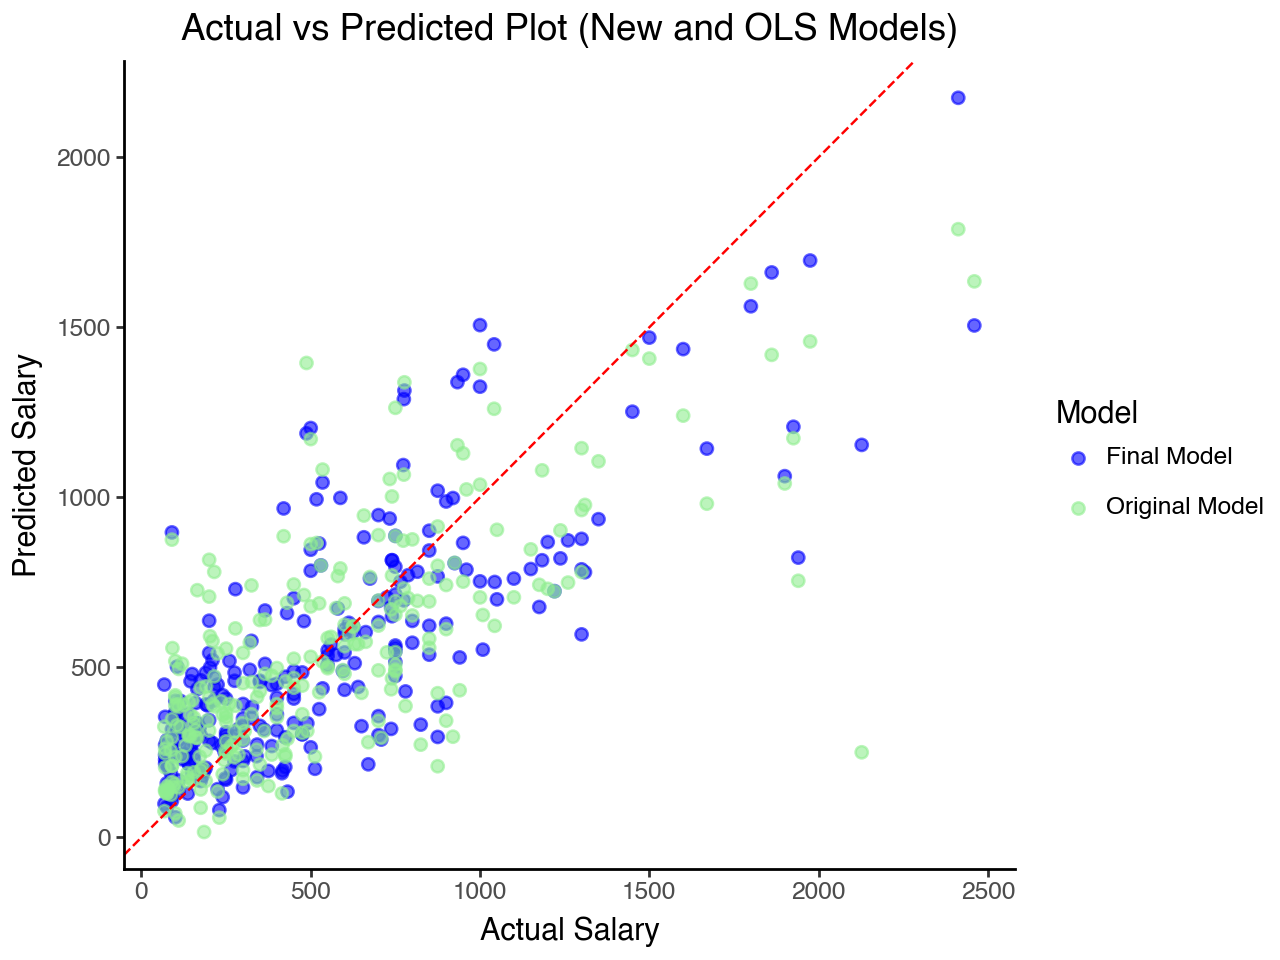

In [52]:
from plotnine import ggplot, aes, geom_point, geom_abline, labs, theme_classic, scale_color_manual

# Create plot for fit of new model
y_pred = gs_final_fitted.predict(X)
y_pred_og = pipeline_ols_1.predict(X)

# Create results dataframe with both sets of predictions
results_df = pd.DataFrame({
    'Actual': y,
    'Final Model': y_pred,
    'Original Model': y_pred_og
})

# Melt the dataframe to long format for easier plotting
results_df_long = results_df.melt(id_vars='Actual', value_vars=['Final Model', 'Original Model'], 
                                  var_name='Model', value_name='Predicted')

# Create the plot
plot_final = (
    ggplot(results_df_long, aes(x='Actual', y='Predicted', color='Model')) +
    geom_point(alpha=0.6, size=2) +
    geom_abline(intercept=0, slope=1, color="red", linetype="dashed") + 
    scale_color_manual(values={'Final Model': 'blue', 'Original Model': 'lightgreen'}) +
    labs(title="Actual vs Predicted Plot (New and OLS Models)", 
         x="Actual Salary", 
         y="Predicted Salary", 
         color="Model") +
    theme_classic()
)

plot_final.show()



In this visualization we can see the difference in how the our new model compares to our original linear regression with every feature included. We can see that our refined model outperforms our original model by looking at the spread of data about the y=x line. We can see that there is less error for the new model, allowing us to predict closer to the actual salary. Thus, we have successfully found I model that better explains the data.